In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal as lps
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KernelDensity

import matplotlib.dates as mdates
from  anomaly_utils import *
# reload anomaly_utils when it changes
# auto reload the utils
%load_ext autoreload
%autoreload  1


# manual label data
## this is already done ./data/manual_label.csv

In [2]:
# read zipfile
df = pd.read_csv('data/data_selection_17_23.csv')

In [3]:
df=add_datetime(df)

# start label df 
df['anomaly_temperature']=False
df['anomaly_humidity']=False    
df['anomaly_voltage']=False
df['anomaly_light']=False

In [4]:
# all temperature above 30 is anomaly
df.loc[df['temperature']>38,'anomaly_temperature']=True
# all temperature below 10 is anomaly
df.loc[df['temperature']<10,'anomaly_temperature']=True
# all missing temperature is anomaly
# df.loc[df['temperature'].isnull(),'anomaly_temperature']=True
# node 4 after 7500 is anomaly
df.loc[(df['nodeid']==4),'anomaly_temperature'][7500:]=True
# node 6 after 7500 is anomaly
df.loc[(df['nodeid']==6),'anomaly_temperature'][7500:]=True
# node 13 after 14000 is anomaly
df.loc[(df['nodeid']==13),'anomaly_temperature'][14000:]=True
# node 15 is anomaly
df.loc[(df['nodeid']==15),'anomaly_temperature']=True
# node 16 is anomaly
df.loc[(df['nodeid']==16),'anomaly_temperature']=True
# node 17 is anomaly
df.loc[(df['nodeid']==17),'anomaly_temperature']=True
# node 18 is anomaly
df.loc[(df['nodeid']==18),'anomaly_temperature']=True
# node 19 after 7500 is anomaly
df.loc[(df['nodeid']==19),'anomaly_temperature'][7500:]=True
# node 19 first 2000 is anomaly
df.loc[np.logical_and(df['nodeid']==19,df.index<=107964),'anomaly_temperature']=True
# node 20 is anomaly
df.loc[(df['nodeid']==20),'anomaly_temperature']=True
# node 21 after 14000 is anomaly
df.loc[(df['nodeid']==21),'anomaly_temperature'][14000:]=True
# node 27 has anomaly from 14500 to 15000 where temperature >20.50
select_node=df.loc[df['nodeid']==27,'temperature'][14500:15000]
df.loc[(select_node[select_node>20.50]).index,'anomaly_temperature']=True
# node 35 after 7500 is anomaly
df.loc[(df['nodeid']==35),'anomaly_temperature'][7500:]=True
# node 40 / index 905079 is anomaly
df.loc[905079,'anomaly_temperature']=True
# node 46 after 13500 is anomaly
df.loc[(df['nodeid']==46),'anomaly_temperature'][13500]=True

# if temperature is NaN, then it is not anomaly
df.loc[df['temperature'].isnull(),'anomaly_temperature']=False


In [5]:
# label humidity
# all humidity above 100 is anomaly
df.loc[df['humidity']>100,'anomaly_humidity']=True
# node 6 after 583234 is anomaly
df.loc[np.logical_and(df['nodeid']==6,df.index>583234),'anomaly_humidity']=True
# all humidity below 20 is anomaly
df.loc[df['humidity']<20,'anomaly_humidity']=True
# node 16 is anomaly
df.loc[(df['nodeid']==16),'anomaly_humidity']=True
# node 17 is anomaly
df.loc[(df['nodeid']==17),'anomaly_humidity']=True
# node 19 after index 464256 is anomaly
df.loc[np.logical_and(df['nodeid']==19,df.index>464256),'anomaly_humidity']=True
# node 35 after 583234 is anomaly
df.loc[np.logical_and(df['nodeid']==35,df.index>583234),'anomaly_humidity']=True


# if temperature is NaN, then it is not anomaly
df.loc[df['humidity'].isnull(),'anomaly_humidity']=False

In [6]:
# label voltage
# all voltage below 2.3 is anomaly
df.loc[df['voltage']<2.25,'anomaly_voltage']=True
for node_id in range(1,55):
    # select node, if the voltage change is more than 0.05, then it is anomaly
    select_node=df.loc[df['nodeid']==node_id,'voltage']
    df.loc[select_node.loc[(select_node.diff()>0.05)].index,'anomaly_voltage']=True
    df.loc[select_node.loc[(select_node.diff()<-0.05)].index,'anomaly_voltage']=True
    

<Figure size 800x500 with 0 Axes>

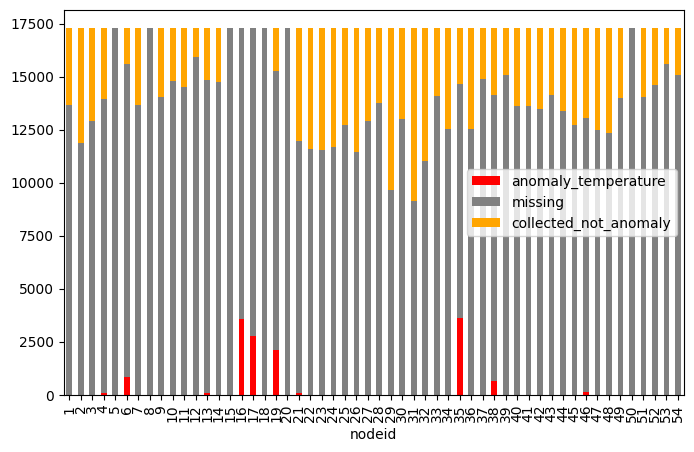

In [7]:
plot_bar_anomaly_good_missing(df,'temperature')

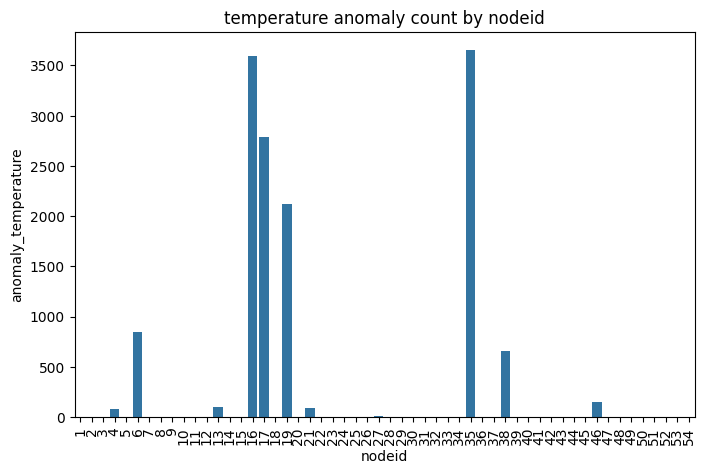

In [8]:
plot_anomaly_by_nodeid(df,'temperature')    

In [32]:
# save df
# drop column dt and datetime
df.drop(columns=['dt','datetime','anomaly_light'],inplace=True)
# to save space, convert boolean to int8
df['anomaly_temperature']=df['anomaly_temperature'].astype(np.int8)
df['anomaly_humidity']=df['anomaly_humidity'].astype(np.int8)
df['anomaly_voltage']=df['anomaly_voltage'].astype(np.int8)

df.to_csv('./data/manual_label.csv',index=False)

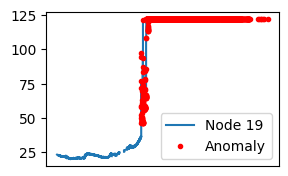

In [33]:
# show anomaly by nodeid

for idx in [19]:
    plt.figure(figsize=(3,2))
    data=df[df['nodeid']==idx][3000:]
    # filter out the anomaly data
    sel='temperature'
    data[sel].plot(label=f'Node {idx}')
    
    anomaly_data = data[data[f'anomaly_{sel}']==True]
    anomaly_data[sel].plot(style='r.',label='Anomaly')
    
    # plt.legend(loc='upper left')
    # plt.title('Node '+str(idx))

    # don't show x-axis
    plt.xticks([])
    # plt.xticks(rotation=45)
    plt.legend()
    # plt.show()

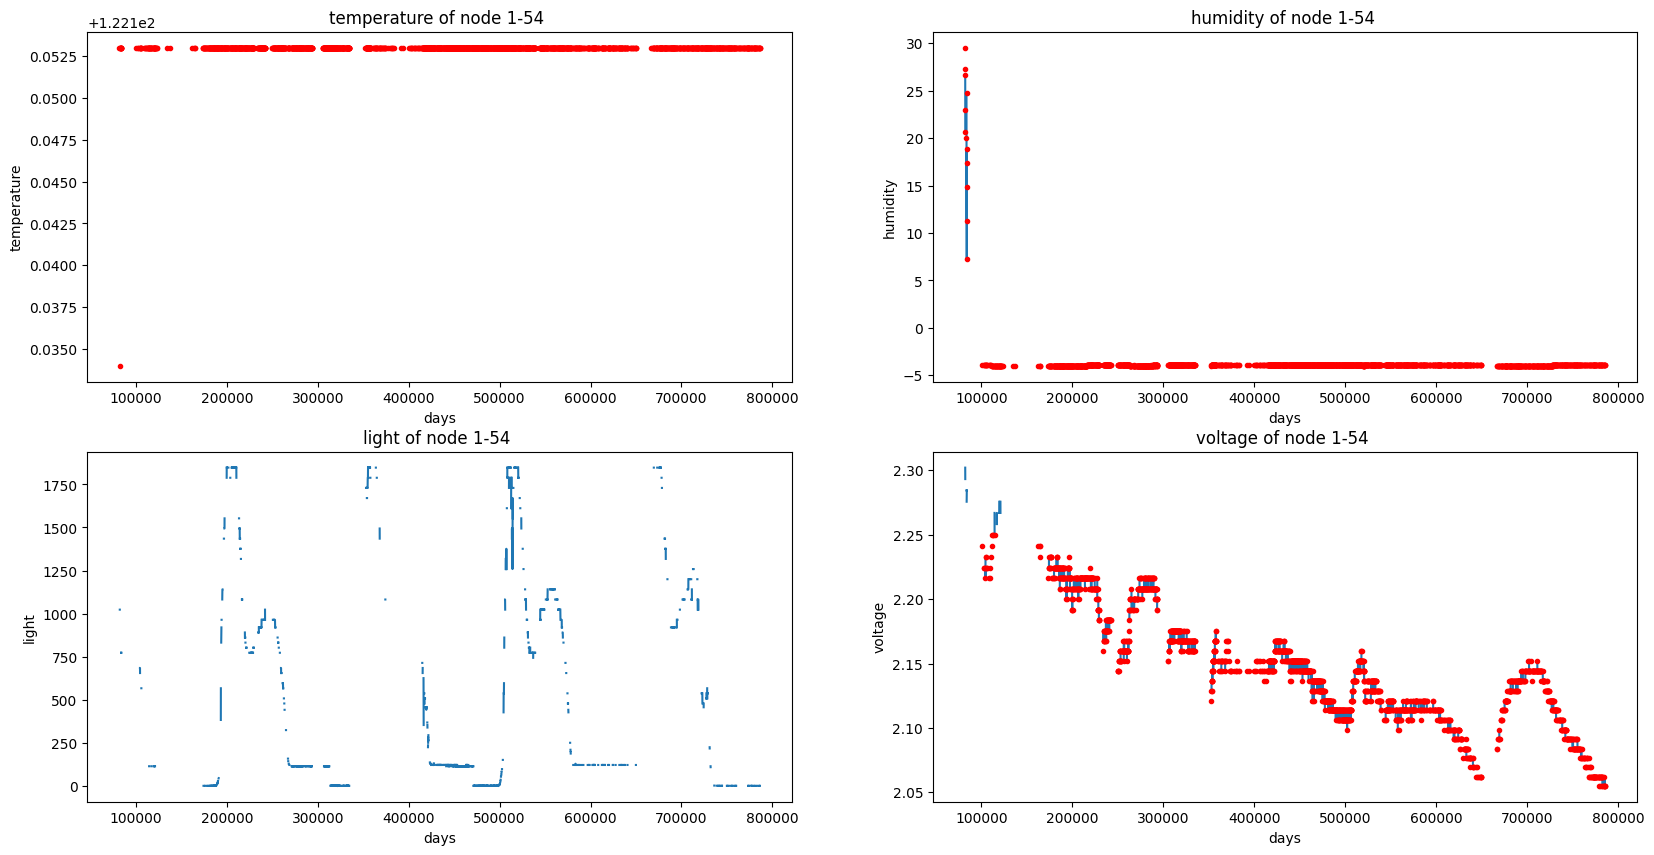

In [58]:
# how to find anomaly across nodeid
# 4 subplots (2,2)
fig, ax = plt.subplots(2,2, figsize=(20,10))

# plot temperature
for node in [17 ]:
# for node in [13,14,15,16,17,18,19 ]:
    df_node = df[df['nodeid']==node]
    anomaly_data = df_node[df_node['anomaly_temperature']==True]
    ax[0,0].plot(df_node['temperature'])
    ax[0,0].plot(anomaly_data['temperature'],'r.')
    
    ax[0,1].plot( df_node['humidity'])    
    anomaly_data = df_node[df_node['anomaly_humidity']==True]
    ax[0,1].plot(anomaly_data['humidity'],'r.')
    
    ax[1,0].plot( df_node['light'])
    ax[1,1].plot( df_node['voltage'])
    anomaly_data = df_node[df_node['anomaly_voltage']==True]
    ax[1,1].plot(anomaly_data['voltage'],'r.')
    
    ax[0,0].set_title(f'temperature of node 1-54 ')
    ax[0,1].set_title(f'humidity of node 1-54 ')
    ax[1,0].set_title(f'light of node 1-54 ')
    ax[1,1].set_title(f'voltage of node 1-54 ')

ax[0,0].set_xlabel('days')
ax[0,0].set_ylabel('temperature')
ax[0,1].set_xlabel('days')
ax[0,1].set_ylabel('humidity')
ax[1,0].set_xlabel('days')
ax[1,0].set_ylabel('light')
ax[1,1].set_xlabel('days')
ax[1,1].set_ylabel('voltage')
    
plt.show()

## start to look at the labeled data

In [37]:
labeled_df=pd.read_csv('./data/manual_label.csv')
labeled_df['dt']=pd.to_datetime(labeled_df['timestamp'], unit='s')    
labeled_df['datetime'] = labeled_df['dt'].dt.strftime('%Y-%m-%d %H:%M:%S')
# convert int8 to boolean
labeled_df['anomaly_temperature']=labeled_df['anomaly_temperature'].astype(bool)
labeled_df['anomaly_humidity']=labeled_df['anomaly_humidity'].astype(bool)
labeled_df['anomaly_voltage']=labeled_df['anomaly_voltage'].astype(bool)
labeled_df

,timestamp,nodeid,temperature,humidity,voltage,light,anomaly_temperature,anomaly_humidity,anomaly_voltage,dt,datetime
0,1468800,1,NaN,NaN,NaN,NaN,False,False,False,1970-01-18 00:00:00,1970-01-18 00:00:00
1,1468800,2,NaN,NaN,NaN,NaN,False,False,False,1970-01-18 00:00:00,1970-01-18 00:00:00
2,1468800,3,NaN,NaN,NaN,NaN,False,False,False,1970-01-18 00:00:00,1970-01-18 00:00:00
3,1468800,4,NaN,NaN,NaN,NaN,False,False,False,1970-01-18 00:00:00,1970-01-18 00:00:00
4,1468800,5,NaN,NaN,NaN,NaN,False,False,False,1970-01-18 00:00:00,1970-01-18 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
933115,1987170,50,NaN,NaN,NaN,NaN,False,False,False,1970-01-23 23:59:30,1970-01-23 23:59:30
933116,1987170,51,NaN,NaN,NaN,NaN,False,False,False,1970-01-23 23:59:30,1970-01-23 23:59:30
933117,1987170,52,NaN,NaN,NaN,NaN,False,False,False,1970-01-23 23:59:30,1970-01-23 23:59:30
933118,1987170,53,NaN,NaN,NaN,NaN,False,False,False,1970-01-23 23:59:30,1970-01-23 23:59:30


In [38]:
# group by nodeid and anomaly_temperature and count the size, 
sel='anomaly_temperature'
sel='anomaly_humidity'
sel='anomaly_voltage'
df_an=labeled_df[labeled_df[sel]==True]
df_an.groupby(['nodeid',sel]).size().unstack().sort_values(by=True,ascending=False)

anomaly_voltage,True
nodeid,
17,2735
16,2535
35,788
19,292
46,223
22,155
6,60
13,13
26,4


In [39]:
# print some stats
# how many data is nan
print('nan count')
print(labeled_df.isnull().sum())

nan count
timestamp                   0
nodeid                      0
temperature            740462
humidity               740462
voltage                740459
light                  748555
anomaly_temperature         0
anomaly_humidity            0
anomaly_voltage             0
dt                          0
datetime                    0
dtype: int64


In [44]:
# how many anomaly data
print('anomaly count')
print(labeled_df['anomaly_temperature'].sum())  
print(labeled_df['anomaly_humidity'].sum())
print(labeled_df['anomaly_voltage'].sum())
# anomaly percentage: anomaly count/total non-nan data
print('anomaly percentage')
print(labeled_df['anomaly_temperature'].sum()/labeled_df['temperature'].notnull().sum())
print(labeled_df['anomaly_humidity'].sum()/labeled_df['humidity'].notnull().sum())
print(labeled_df['anomaly_voltage'].sum()/labeled_df['voltage'].notnull().sum())
# what percentage of data is nan
print('nan percentage')
print(labeled_df['temperature'].isnull().sum()/labeled_df['temperature'].shape[0])
print(labeled_df['humidity'].isnull().sum()/labeled_df['humidity'].shape[0])
print(labeled_df['voltage'].isnull().sum()/labeled_df['voltage'].shape[0])


anomaly count
14093
11099
6813
anomaly percentage
0.073150349323672
0.05760985788288055
0.035362631772906813
nan percentage
0.7935335219478739
0.7935335219478739
0.7935303069272976


In [41]:
# nan is not labeled as anomaly
print('anomaly and nan count')
print(labeled_df.loc[labeled_df['temperature'].isnull(),'anomaly_temperature'].sum())
print(labeled_df.loc[labeled_df['humidity'].isnull(),'anomaly_humidity'].sum())
print(labeled_df.loc[labeled_df['voltage'].isnull(),'anomaly_voltage'].sum())

anomaly and nan count
0
0
0


In [57]:
# mean value of temperature, humidity, voltage
print('mean value')
print(labeled_df['temperature'].mean())
print(labeled_df['humidity'].mean())
print(labeled_df['voltage'].mean())
# std value of temperature, humidity, voltage
# print('std value')
# print(labeled_df['temperature'].std())
# print(labeled_df['humidity'].std())
# print(labeled_df['voltage'].std())
# mean value of temperature, humidity, voltage when anomaly if True
print('mean value when anomaly is True')
print(labeled_df.loc[labeled_df['anomaly_temperature'],'temperature'].mean())
print(labeled_df.loc[labeled_df['anomaly_humidity'],'humidity'].mean())
print(labeled_df.loc[labeled_df['anomaly_voltage'],'voltage'].mean())
print('mean value when anomaly is False')
print(labeled_df.loc[~labeled_df['anomaly_temperature'],'temperature'].mean())
print(labeled_df.loc[~labeled_df['anomaly_humidity'],'humidity'].mean())
print(labeled_df.loc[~labeled_df['anomaly_voltage'],'voltage'].mean())

mean value
28.609995118811565
38.904095364125006
2.415115785710809
mean value when anomaly is True
111.71448387142553
4.991535378106135
2.191912621580802
mean value when anomaly is False
22.05108626214543
40.97722587974156
2.4232981883044196
